In [2]:
######################
# This notebook provides a set of utilities to view sampled blocks and 
# and visualize potential expansions of a network if Adaptive Cluster Sampling expansion thresholds are met
######################

# Google earth engine
import ee
# Authenticate and initialize Earth Engine API
ee.Authenticate()  # Only required once
ee.Initialize(
      opt_url='https://earthengine-highvolume.googleapis.com'
)

# Built-in modules
import os
import subprocess
from pathlib import Path
import datetime
from datetime import date
from urllib.request import urlopen
from typing import Any, Optional, Tuple

# Basics of Python data handling and visualization
import math
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt

# Geospatial
import geemap
import geopandas as gpd
from shapely import wkt
from shapely.geometry import (
    shape,
    Point,
    LineString,
    Polygon,
    MultiPoint,
    MultiLineString,
    MultiPolygon
)
from shapely.validation import make_valid
import geojson
import folium
from geopy.distance import great_circle
from gadm import GADMDownloader
import rasterio
from rasterio import plot
import xarray as xr  # It may need Dask library https://docs.dask.org/en/stable/install.html
import rioxarray  # noqa: F401 # Its necesary for xarray.open_mfdataset() with engine `rasterio`
import osmnx as ox

# The following is not a package. It is a file utils.py which should be in the same folder as this notebook.
from utils import (
    get_adjacent_blocks, 
    get_new_adjacent_blocks,
    expand_network,
    plot_osm_base, 
    plot_block_and_adjacent
)



Successfully saved authorization token.


/var/folders/r2/wkhyv2tx5g7gmy_bw0rgxp7w0000gn/T/ipykernel_947/3459196926.py:25: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [79]:
# Other 

%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
# GLOBAL PARAMS:

# Country: Select one of: ["Brazil", "India", "Indonesia", "Ethiopia", "Nigeria"]
COUNTRY = "Nigeria"

# FILE PATHS (GLOBALS)
cdir = os.getcwd()
pdir = os.path.dirname(cdir)
OUTPUTS_FOLDER = os.path.join(pdir, "outputs", COUNTRY)

In [4]:
#########################################
# (1) Open sampling grid for the selected country
#########################################

file = os.path.join(OUTPUTS_FOLDER, "final_sampling_grid.geojson")
# Convert to geopandas dataframe
sampling_grid = gpd.read_file(file)
# Select only blocks in sample 
initial_sample = sampling_grid[sampling_grid['in_sample'] == 1]


Blocks adjacent to 5157: ['4974' '4975' '4976' '5156' '5158' '5338' '5339' '5340']


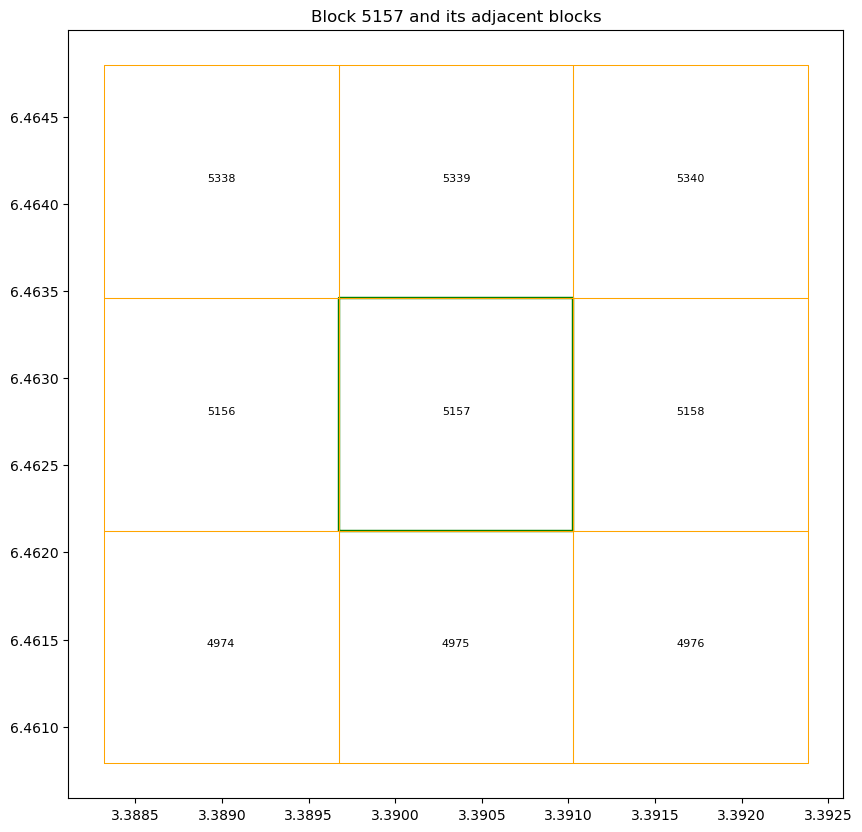

In [82]:
#########################################
# Example 1: Visualize all the adjacent blocks and block ids for a randomly selected (or user defined) block in the initial sample
#########################################

# Randomly select a single block (the origin) from the initial sample
from numpy.random import RandomState
prng = RandomState(1234567890)
origin_block_id = initial_sample.sample(n=1, random_state=prng)['block_id'].values[0]

# Return a list of all adjacent blocks to the selected block
adjacent_blocks_list = get_adjacent_blocks(origin_block_id, sampling_grid)['block_id'].values
print(f"Blocks adjacent to {origin_block_id}: {adjacent_blocks_list}")

# Plot the block and its adjacent blocks
plot_block_and_adjacent(origin_block_id, sampling_grid)



(6.468797000001055, 6.455454000003827, 3.396383999997767, 3.382961000002905)


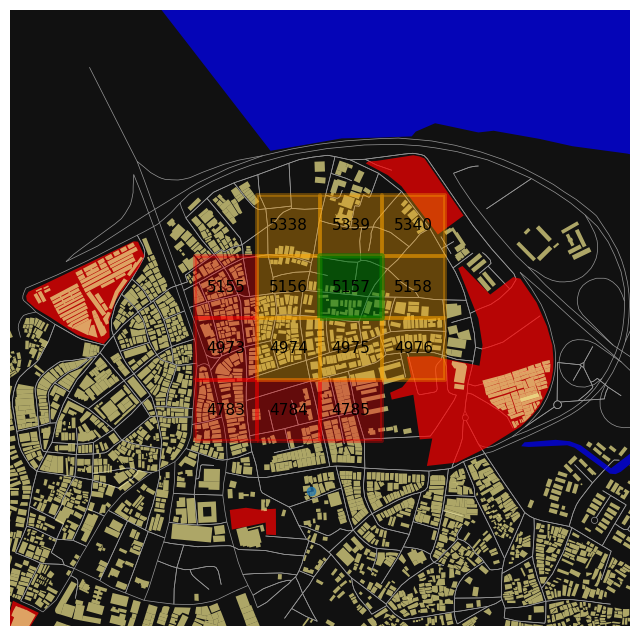

In [83]:
#########################################
# Example 2: Visualize all the adjacent blocks and block ids for two expansion 'rounds' 
#########################################

origin_gdf = sampling_grid[sampling_grid['block_id'] == origin_block_id]
adjacent_blocks_gdf = get_adjacent_blocks(origin_block_id, sampling_grid)
network = pd.concat([origin_gdf, adjacent_blocks_gdf])

edge_block_id = '4974'
new_adjacenet_blocks_gdf = get_new_adjacent_blocks(edge_block_id, network, sampling_grid)
new_network = pd.concat([network, new_adjacenet_blocks_gdf])

# Plot OSM base
plot_osm_base(new_network)
# Plot the new adjacent blocks
new_adjacenet_blocks_gdf.boundary.plot(ax=plt.gca(), color="red", linewidth = 2.75, facecolor = "red", alpha = 0.35)
# Plot the adjacent blocks
adjacent_blocks_gdf.boundary.plot(ax=plt.gca(), color="orange", linewidth = 2.75, facecolor = "orange", alpha = 0.35)
# Plot the origin block
origin_gdf.boundary.plot(ax=plt.gca(), color="green", linewidth = 4, aspect = 1, facecolor = "green", alpha = 0.55)
# Display block ids of blocks in the network
for idx, row in new_network.iterrows():
    plt.text(row.geometry.centroid.x, row.geometry.centroid.y, row['block_id'], fontsize=11, color = "black", ha='center', va='center')



In [84]:
####################################################################
# Example 2: VISUALIZE NETWORK OVER INTERACTIVE MAP
###################################################################

# Converting assets to ee objects
origin_ee = geemap.gdf_to_ee(origin_gdf)
adjacent_blocks_ee = geemap.gdf_to_ee(adjacent_blocks_gdf)
new_adjacenet_blocks_ee = geemap.gdf_to_ee(new_adjacenet_blocks_gdf)
network_ee = geemap.gdf_to_ee(new_network)

m = geemap.Map()
m.centerObject(network_ee, 16)

# Add origin block to the map
m.add_layer(origin_ee, {'color': 'green', "width": 2}, "Origin block")
# Add first round expansion to map
m.add_layer(adjacent_blocks_ee, {'color': 'orange', "width": 2}, "1st expansion")
# Add second round expansion to map
m.add_layer(new_adjacenet_blocks_ee, {'color': 'red', "width": 2}, "2nd expansion")

m

Map(center=[6.462125498222141, 3.3896724977096016], controls=(WidgetControl(options=['position', 'transparent_…

In [19]:
##############################################
# Example 3: Program that dynamically creates a network from a single block based on user input
##############################################
from numpy.random import RandomState
prng = RandomState(1234567890)
# Randomly select a single block (the origin) from the initial sample
origin_block_id = initial_sample.sample(n=1, random_state=prng)['block_id'].values[0]

# Expand the network dynamically
final_network_gdf = expand_network(origin_block_id, sampling_grid)


Starting network expansion from block ID (origin):  5157
New edge blocks for round 1:  ['4974', '4975', '4976', '5156', '5158', '5338', '5339', '5340']
New edge blocks for round 2:  ['4973', '5155', '5337', '4785', '4786', '4787', '4977', '5159']
New edge blocks for round 3:  ['4972', '5154', '5336', '4588', '4589', '4590', '4788', '4978']
New edge blocks for round 4:  ['4391', '4392', '4393', '4587']
Final network consists of block IDs:  ['5157', '4974', '4975', '4976', '5156', '5158', '5338', '5339', '5340', '4973', '5155', '5337', '4785', '4786', '4787', '4977', '5159', '4972', '5154', '5336', '4588', '4589', '4590', '4788', '4978', '4391', '4392', '4393', '4587']
Round information: 
    block_id round
0      5157     0
1      4974     1
2      4975     1
3      4976     1
4      5156     1
5      5158     1
6      5338     1
7      5339     1
8      5340     1
9      4973     2
10     5155     2
11     5337     2
12     4785     2
13     4786     2
14     4787     2
15     4977    

In [20]:
####################################################################
# Example 3: Visualize the final network over an interactive map
###################################################################

# Converting assets to ee objects
network_ee = geemap.gdf_to_ee(final_network_gdf)

m = geemap.Map()
m.centerObject(network_ee, 16)

########################
# BLOCK NETWORK
########################

# Return list of unique round values in final_network_gdf
unique_rounds = final_network_gdf['round'].unique().tolist()

# Create a list of hex colors for each round
palette = ['#a6cee3','#1f78b4','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f','#ff7f00','#cab2d6']
colors = palette[:len(unique_rounds)]

styled_network = geemap.ee_vector_style(
    network_ee, column='round', labels=unique_rounds, fillColor=colors, width = 2
)

# Add origin block to the map
m.add_layer(styled_network, {}, "Network")
m.add_labels(
data=network_ee,
column="block_id",
font_size="10pt",
font_color="black",
font_family="arial",
font_weight="plain",
draggable = False
)

m

Map(center=[6.461227601959681, 3.390677666550631], controls=(WidgetControl(options=['position', 'transparent_b…

(6.470131999999178, 6.4527830000030075, 3.397740000002118, 3.384316999998273)


/var/folders/r2/wkhyv2tx5g7gmy_bw0rgxp7w0000gn/T/ipykernel_947/4104684990.py:12: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  for x, y, label in zip(final_network_gdf.centroid.x, final_network_gdf.centroid.y, final_network_gdf['block_id']):


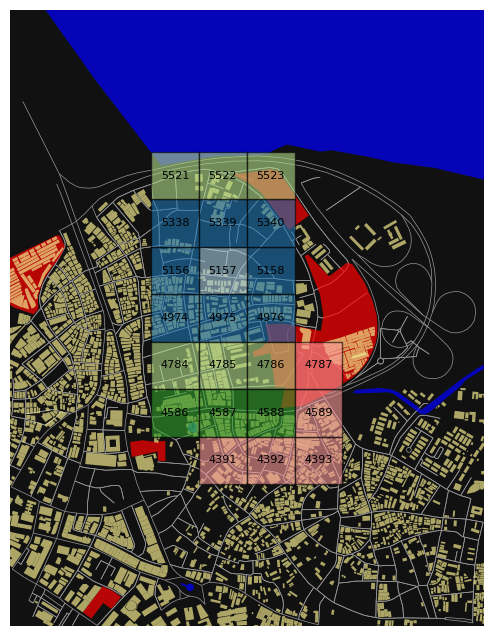

In [10]:
####################################################################
# Example 3: Visualize the final network over an static map
###################################################################

plot_osm_base(final_network_gdf)

# For each group of blocks in gdf defined by the column "round", use a different color
for round, group in final_network_gdf.groupby('round'):
    group.plot(ax=plt.gca(), facecolor=colors[unique_rounds.index(round)], edgecolor = 'black', linewidth=1, alpha = 0.6)

# Display block ids at center of each block: 
for x, y, label in zip(final_network_gdf.centroid.x, final_network_gdf.centroid.y, final_network_gdf['block_id']):
    plt.text(x, y, label, fontsize=8, ha='center', va='center')

# Save plot
plt.savefig(os.path.join(OUTPUTS_FOLDER, "example_network.png"), dpi=300)
